# Walmart Sales Forecasting

![alt text](pic1.png)

Walmart is an American multinational retail corporation whose data has been made available for M5 forecasting competition for forecasting.
The objective of this project is to predict 28 days ahead point sales forecast for Walmart.
Data is hierarchical grouped unit sales data, starting at the product-store level and being aggregated to that of product departments, product categories, stores, and three geographical areas. 

- Challenges: 
    - Dataset size (Need high computation power)
    - Uncertainty in predictions due to events
- Impact:
    - Preparing the budget 
    - Planning and scheduling production
    - Inventory management
    - Developing a pricing strategy


![alt text](pic2.png)

# 1. Basic Operations

## 1.1 Imports

In [47]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import cycle, islice
import statsmodels.api as sm
from pylab import rcParams

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from matplotlib.ticker import MaxNLocator

from datetime import datetime

In [48]:
import warnings
warnings.filterwarnings('ignore')

## 1.2 Loading files

In [49]:
calendar = pd.read_csv("calendar.csv")
sell_df = pd.read_csv("sell_prices.csv")
train_val_df = pd.read_csv("sales_train_validation.csv")
train_eval_df = pd.read_csv("sales_train_evaluation.csv")
sub_df = pd.read_csv("sample_submission.csv")

In [50]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [5]:
sell_df.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [141]:
train_val_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

## 1.3 Descriptive Statistics

In [7]:
calendar.describe()

wm_yr_wk         wday        month         year      snap_CA  \
count   1969.000000  1969.000000  1969.000000  1969.000000  1969.000000   
mean   11347.086338     3.997461     6.325546  2013.288471     0.330117   
std      155.277043     2.001141     3.416864     1.580198     0.470374   
min    11101.000000     1.000000     1.000000  2011.000000     0.000000   
25%    11219.000000     2.000000     3.000000  2012.000000     0.000000   
50%    11337.000000     4.000000     6.000000  2013.000000     0.000000   
75%    11502.000000     6.000000     9.000000  2015.000000     1.000000   
max    11621.000000     7.000000    12.000000  2016.000000     1.000000   

           snap_TX      snap_WI  
count  1969.000000  1969.000000  
mean      0.330117     0.330117  
std       0.470374     0.470374  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000

In [8]:
sell_df.describe()

wm_yr_wk    sell_price
count  6.841121e+06  6.841121e+06
mean   1.138294e+04  4.410952e+00
std    1.486100e+02  3.408814e+00
min    1.110100e+04  1.000000e-02
25%    1.124700e+04  2.180000e+00
50%    1.141100e+04  3.470000e+00
75%    1.151700e+04  5.840000e+00
max    1.162100e+04  1.073200e+02

## 1.4 Checking Null values

In [9]:
calendar.isnull().sum().sort_values(ascending = False)

event_type_2    1964
event_name_2    1964
event_type_1    1807
event_name_1    1807
snap_WI            0
snap_TX            0
snap_CA            0
d                  0
year               0
month              0
wday               0
weekday            0
wm_yr_wk           0
date               0
dtype: int64

In [10]:
sell_df.isnull().sum().sort_values(ascending = False)

sell_price    0
wm_yr_wk      0
item_id       0
store_id      0
dtype: int64

In [11]:
train_val_df.isnull().sum().sort_values(ascending = False)

d_1913    0
d_638     0
d_626     0
d_627     0
d_628     0
         ..
d_1278    0
d_1279    0
d_1280    0
d_1281    0
id        0
Length: 1919, dtype: int64

# 2.1 Exploratory Data Analysis


The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI). In this respect, the bottom-level of the hierarchy, i.e., product-store unit sales can be mapped across either product categories or geographical regions.

The historical data range from 2011-01-29 to 2016-06-19. Thus, the products have a (maximum) selling history of 1,941  days / 5.4 years (test data of h=28 days not included). 

![alt text](DataImage.png "Data Hierarchy")

### 2.1.1 States

Text(0.5, 1.0, 'Number of sales by State')

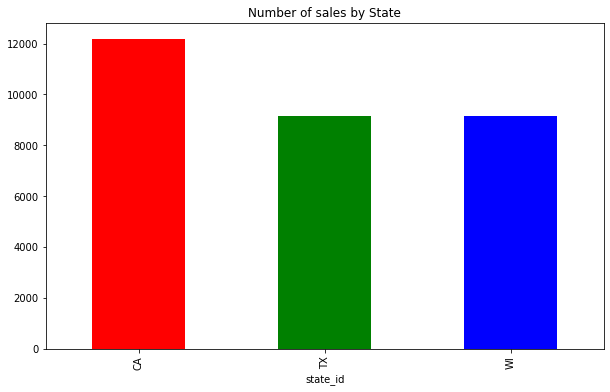

In [12]:
temp1 = train_val_df.groupby(['state_id'])['store_id'].count()
plt.figure(figsize=(10,6))
temp1.plot(kind='bar',color=['r', 'g', 'b'])
plt.title("Number of sales by State")

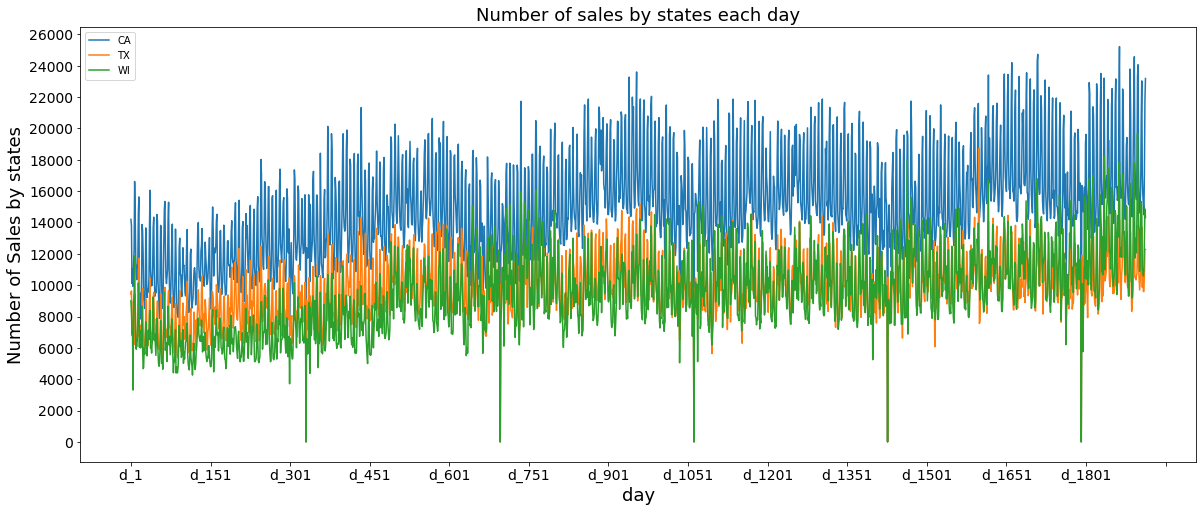

In [13]:
temp1 = train_val_df.groupby(['state_id']).sum()
fig,axes=plt.subplots(1,1, figsize=(20, 8))
plt.tick_params(labelsize=14)
plt.plot(temp1.loc['CA'])
plt.plot(temp1.loc['TX'])
plt.plot(temp1.loc['WI'])
plt.legend(temp1.index)
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by states each day", fontsize = 18)
axes.set_xlabel("day", fontsize = 18)
axes.set_ylabel("Number of Sales by states", fontsize = 18)
plt.show()

plt.show()

### 2.1.2 Store 

Text(0.5, 1.0, 'Number of sales by State')

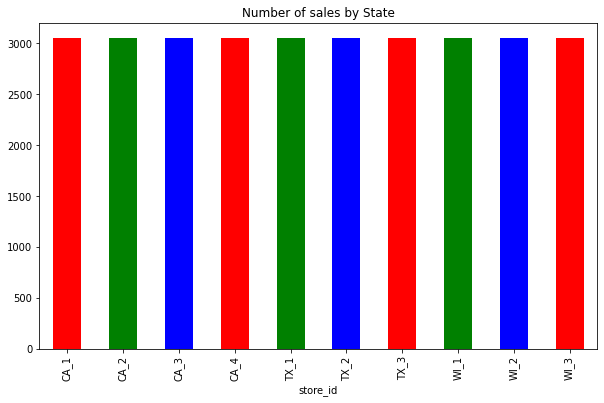

In [14]:
temp2 = train_val_df.groupby(['store_id'])['state_id'].count()
plt.figure(figsize=(10,6))
temp2.plot(kind='bar',color=['r', 'g', 'b'])
plt.title("Number of sales by State")

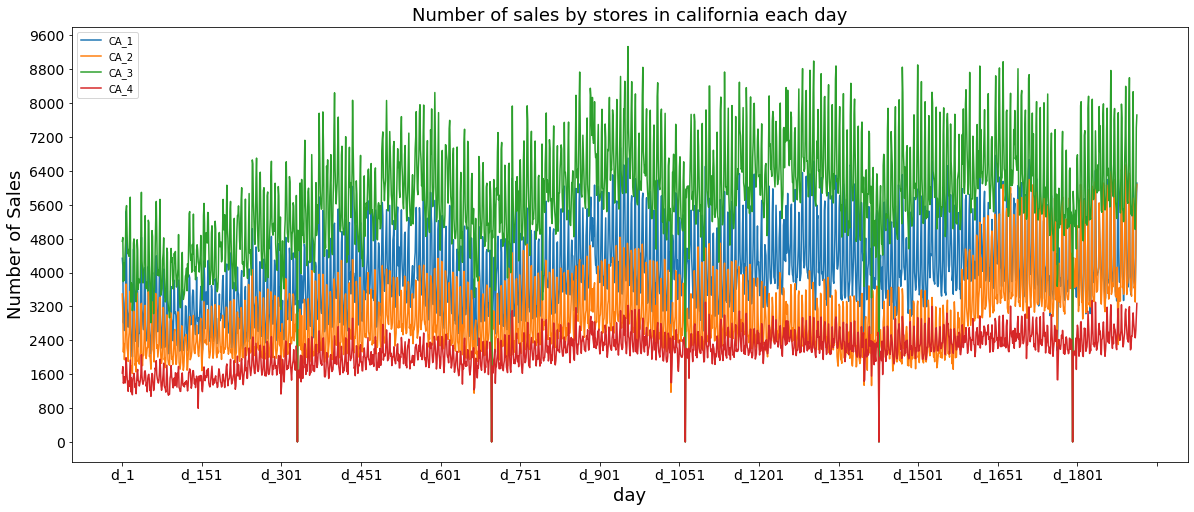

In [15]:
temp2 = train_val_df.groupby(['store_id']).sum()
fig,axes=plt.subplots(1,1, figsize=(20, 8))
plt.tick_params(labelsize=14)
plt.plot(temp2.loc['CA_1'])
plt.plot(temp2.loc['CA_2'])
plt.plot(temp2.loc['CA_3'])
plt.plot(temp2.loc['CA_4'])

plt.legend(temp2.index)
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by stores in california each day", fontsize = 18)
axes.set_xlabel("day", fontsize = 18)
axes.set_ylabel("Number of Sales", fontsize = 18)
plt.show()


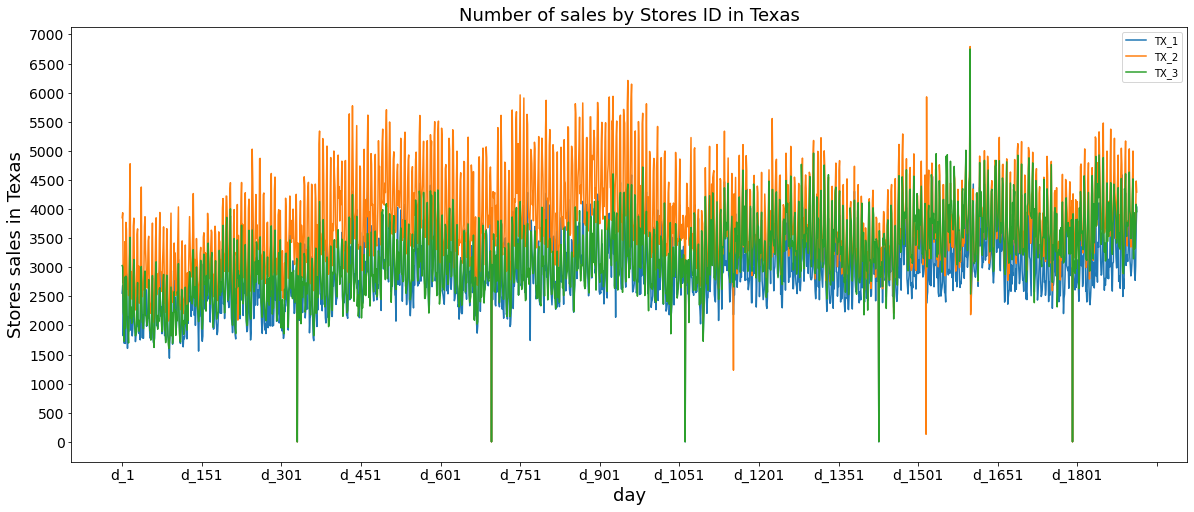

In [16]:
fig,axes=plt.subplots(1,1, figsize=(20, 8))
plt.tick_params(labelsize=14)
plt.plot(temp2.loc['TX_1'])
plt.plot(temp2.loc['TX_2'])
plt.plot(temp2.loc['TX_3'])
plt.legend(['TX_1','TX_2','TX_3'])
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by Stores ID in Texas", fontsize = 18)
axes.set_xlabel("day", fontsize = 18)
axes.set_ylabel("Stores sales in Texas", fontsize = 18)
plt.show()

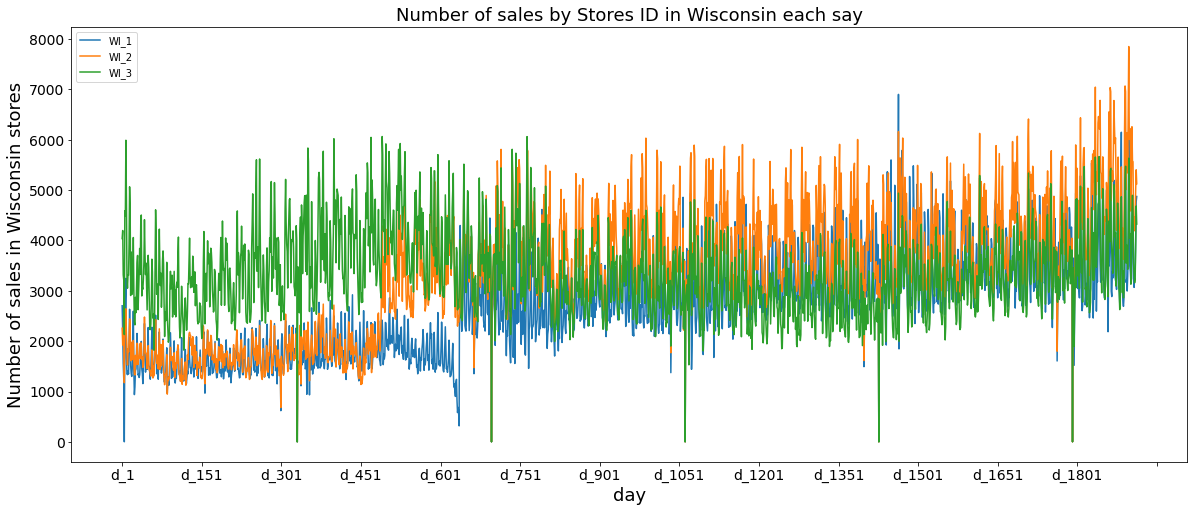

In [17]:
fig,axes=plt.subplots(1,1, figsize=(20, 8))
plt.tick_params(labelsize=14)
plt.plot(temp2.loc['WI_1'])
plt.plot(temp2.loc['WI_2'])
plt.plot(temp2.loc['WI_3'])
plt.legend(['WI_1','WI_2','WI_3'])
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.set_title("Number of sales by Stores ID in Wisconsin each say", fontsize = 18)
axes.set_xlabel("day", fontsize = 18)
axes.set_ylabel("Number of sales in Wisconsin stores", fontsize = 18)
plt.show()

### 2.1.3 category

Text(0.5, 1.0, 'Number of sales within Categories')

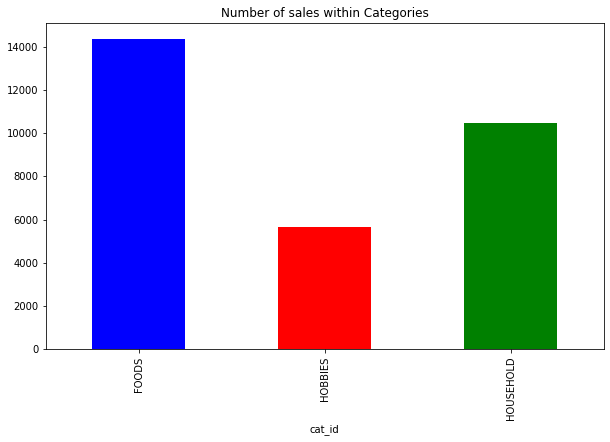

In [18]:
temp3 = train_val_df.groupby(['cat_id'])['dept_id'].count()
plt.figure(figsize=(10,6))
temp3.plot(kind='bar',color=['b', 'r', 'g'])
plt.title("Number of sales within Categories")

In [19]:
category = train_val_df.groupby(['cat_id']).sum()
category

d_1    d_2    d_3    d_4    d_5    d_6    d_7    d_8    d_9  \
cat_id                                                                     
FOODS      23178  22758  17174  18878  14603  22093  20490  27751  24862   
HOBBIES     3764   3357   2682   2669   1814   3220   2944   3986   2899   
HOUSEHOLD   5689   5634   3927   3865   2729   3898   4576   6195   4975   

            d_10  ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  \
cat_id            ...                                                           
FOODS      18901  ...   28682   32007   34497   26151   24948   23632   23317   
HOBBIES     2615  ...    3786    4634    4820    3323    3787    3472    3353   
HOUSEHOLD   4056  ...    9321   11721   12323    8585    8835    8239    8363   

           d_1911  d_1912  d_1913  
cat_id                             
FOODS       26704   31927   32654  
HOBBIES      4085    4787    4683  
HOUSEHOLD    9728   12248   12458  

[3 rows x 1913 columns]

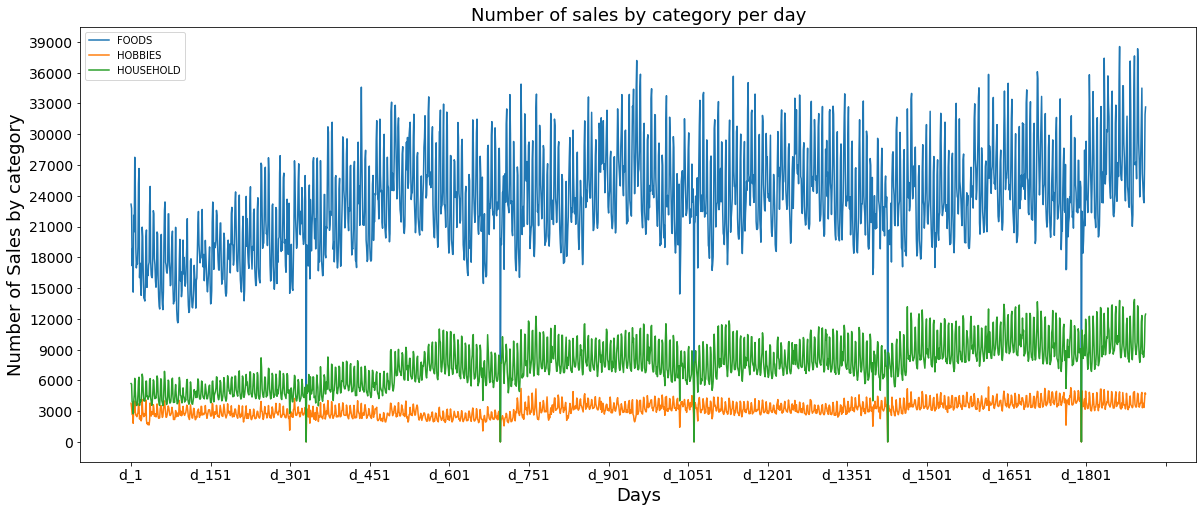

In [20]:

fig,axes=plt.subplots(1,1, figsize=(20, 8))
plt.tick_params(labelsize=14)
plt.plot(category.loc['FOODS'])
plt.plot(category.loc['HOBBIES'])
plt.plot(category.loc['HOUSEHOLD'])
plt.legend(category.index)
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by category per day",fontsize= 18)
axes.set_xlabel("Days", fontsize= 18)
axes.set_ylabel("Number of Sales by category", fontsize= 18)
plt.show()


### 2.1.4 Department

Text(0.5, 1.0, 'Number of sales by Department')

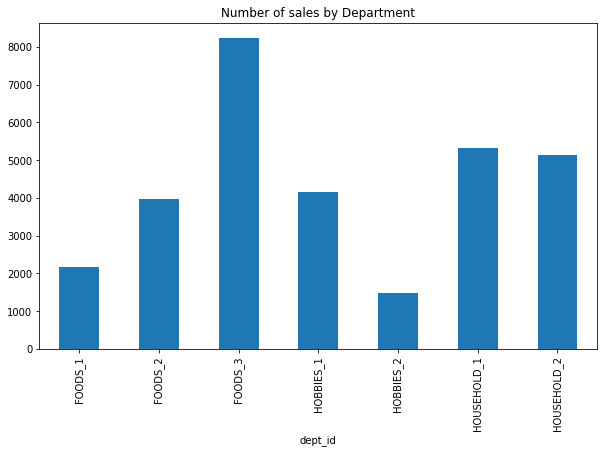

In [21]:
temp4 = train_val_df.groupby(['dept_id'])['item_id'].count()
plt.figure(figsize=(10,6))
temp4.plot(kind='bar')
plt.title("Number of sales by Department")

In [22]:
department = train_val_df.groupby(['dept_id']).sum()
department

d_1    d_2    d_3    d_4    d_5    d_6    d_7    d_8    d_9  \
dept_id                                                                      
FOODS_1       2343   2216   1657   1508   1209   1897   1903   2235   1925   
FOODS_2       4094   4209   3174   3606   2869   4375   3349   4384   4273   
FOODS_3      16741  16333  12343  13764  10525  15821  15238  21132  18664   
HOBBIES_1     3610   3172   2497   2531   1714   3133   2855   3831   2741   
HOBBIES_2      154    185    185    138    100     87     89    155    158   
HOUSEHOLD_1   4105   3858   2827   2732   1802   2664   3161   4334   3494   
HOUSEHOLD_2   1584   1776   1100   1133    927   1234   1415   1861   1481   

              d_10  ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
dept_id             ...                                                   
FOODS_1       1586  ...    3192    3523    3062    2461    2544    2657   
FOODS_2       3684  ...    5661    5792    6588    5247    4942    4734   
FOODS_3      13631  ...   19829   22692   24847   18443   17462   16241   
HOBBIES_1     2514  ...    3367    4220    4325    3038    3420    3141   
HOBBIES_2      101  ...     419     414     495     285     367     331   
HOUSEHOLD_1   2857  ...    7375    9253    9720    6776    6986    6393   
HOUSEHOLD_2   1199  ...    1946    2468    2603    1809    1849    1846   

             d_1910  d_1911  d_1912  d_1913  
dept_id                                      
FOODS_1        2639    3169    3712    3185  
FOODS_2        4446    4974    5524    6473  
FOODS_3       16232   18561   22691   22996  
HOBBIES_1      3014    3678    4397    4226  
HOBBIES_2       339     407     390     457  
HOUSEHOLD_1    6580    7762    9545    9795  
HOUSEHOLD_2    1783    1966    2703    2663  

[7 rows x 1913 columns]

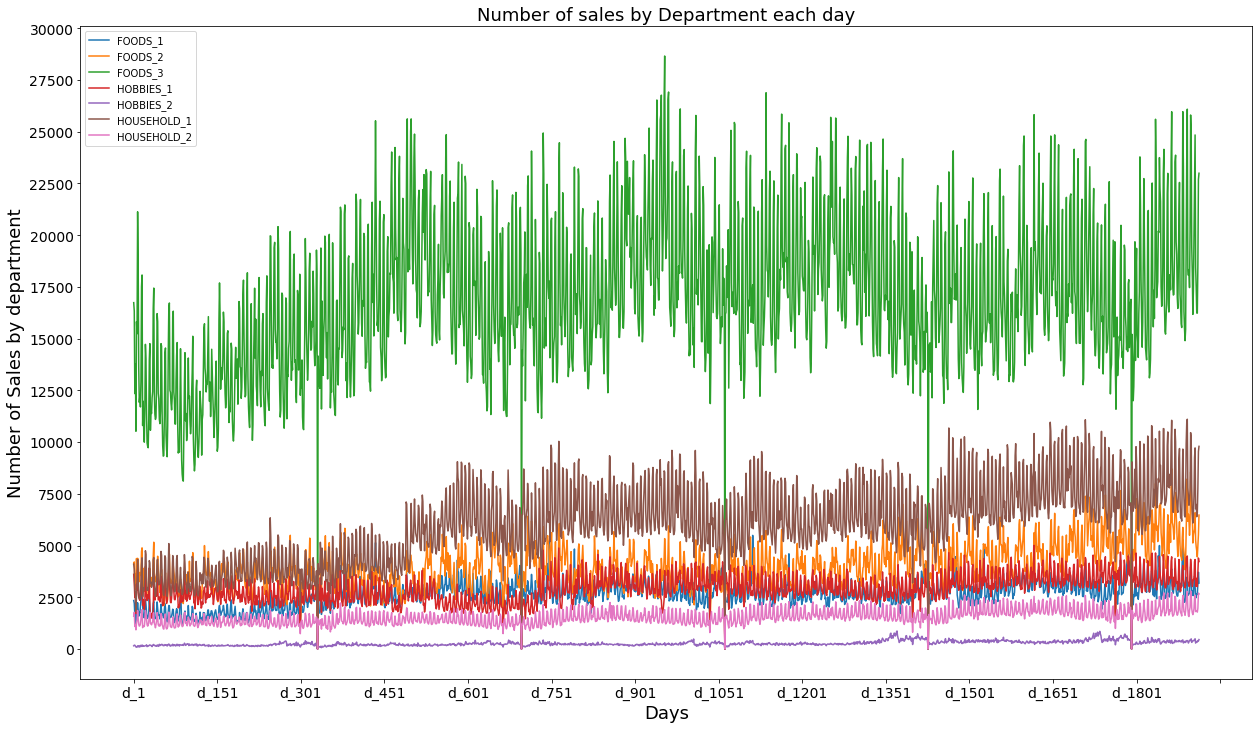

In [23]:
fig,axes=plt.subplots(1,1, figsize=(21, 12))
plt.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.plot(department.loc['FOODS_1'])
plt.plot(department.loc['FOODS_2'])
plt.plot(department.loc['FOODS_3'])
plt.plot(department.loc['HOBBIES_1'])
plt.plot(department.loc['HOBBIES_2'])
plt.plot(department.loc['HOUSEHOLD_1'])
plt.plot(department.loc['HOUSEHOLD_2'])
plt.legend(department.index)
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by Department each day", fontsize= 18)
axes.set_xlabel("Days", fontsize=18)
axes.set_ylabel("Number of Sales by department", fontsize=18)
plt.show()

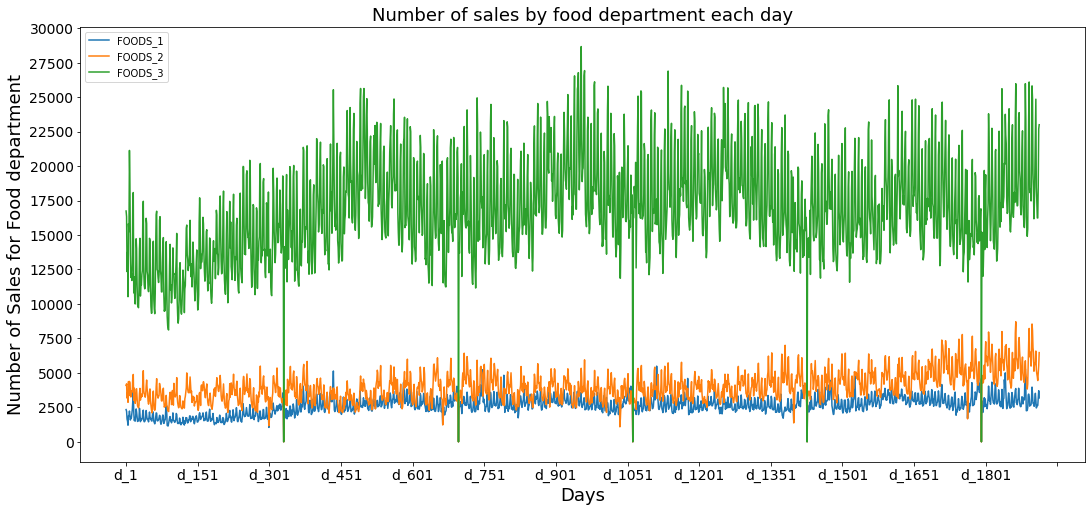

In [24]:
fig,axes=plt.subplots(1,1, figsize=(18, 8))
plt.tick_params(labelsize=14)
plt.plot(department.loc['FOODS_1'])
plt.plot(department.loc['FOODS_2'])
plt.plot(department.loc['FOODS_3'])

plt.legend(department.index)
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by food department each day", fontsize= 18)
axes.set_xlabel("Days",  fontsize= 18)
axes.set_ylabel("Number of Sales for Food department",  fontsize= 18)
plt.show()

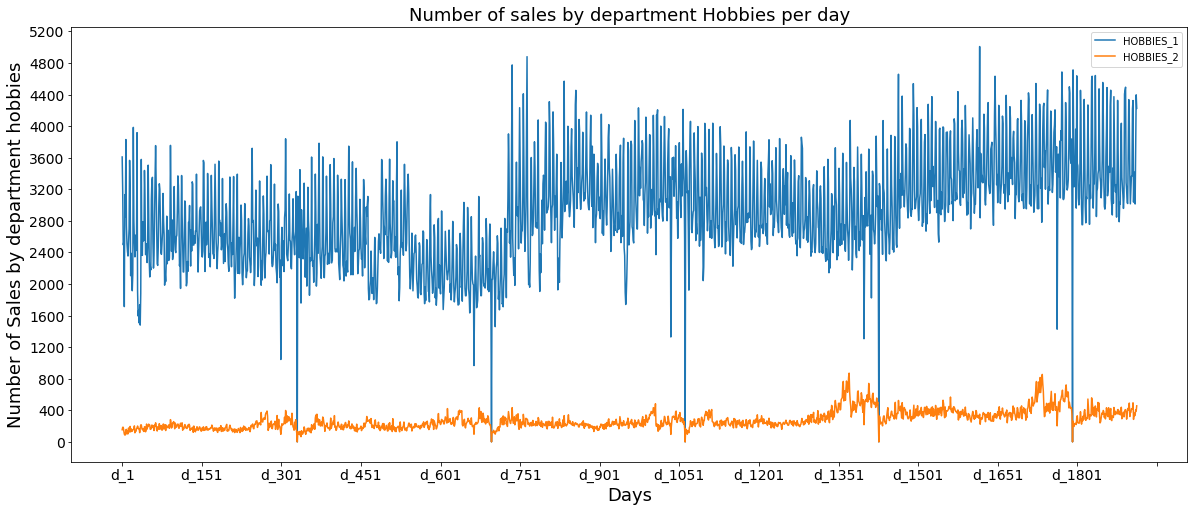

In [25]:
fig,axes=plt.subplots(1,1, figsize=(20, 8))
plt.tick_params(labelsize=14)
plt.plot(department.loc['HOBBIES_1'])
plt.plot(department.loc['HOBBIES_2'])
plt.legend(['HOBBIES_1','HOBBIES_2'])
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by department Hobbies per day",  fontsize= 18)
axes.set_xlabel("Days",  fontsize= 18)
axes.set_ylabel("Number of Sales by department hobbies",  fontsize= 18)
plt.show()

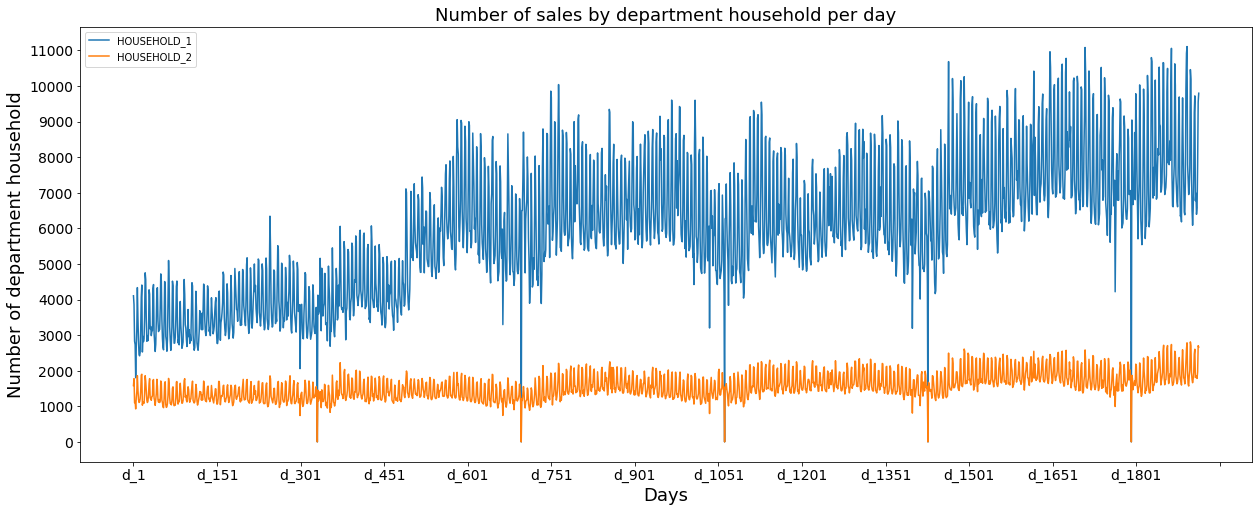

In [26]:
fig,axes=plt.subplots(1,1, figsize=(21, 8))
plt.tick_params(labelsize=14)
plt.plot(department.loc['HOUSEHOLD_1'])
plt.plot(department.loc['HOUSEHOLD_2'])
plt.legend(['HOUSEHOLD_1','HOUSEHOLD_2'])
axes.xaxis.set_major_locator(MaxNLocator(15)) 
axes.yaxis.set_major_locator(MaxNLocator(15))
axes.set_title("Number of sales by department household per day",fontsize= 18)
axes.set_xlabel("Days", fontsize= 18)
axes.set_ylabel("Number of department household", fontsize= 18)
plt.show()

In [27]:
#Removing unnecessary dataframes to free up the space.
# import gc
# del temp1,temp2,temp3,temp4,department, category
# gc.collect();

## 2.2 Downcasting

Reduce the pandas dataframe size automatically. The dataset is very big and when melting is performed it goes above millions of rows so downcasting to reduce the size of data to fit in the memory.

In [28]:
# memory usage reduction
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [29]:
train_sales = downcast(train_val_df)

In [30]:
train_sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

## 2.3 Melting - Coverting wide table to long

The melt() function is used to convert a data frame with several measurement columns into a data frame in this canonical format, which has one row for every observed (measured) value. This was needed to make the d columns into one column suitable for further analysis

In [31]:
grid_df = pd.melt(train_sales, 
                  id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                  var_name = 'd', 
                  value_name = "sales")

In [32]:
grid_df

id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
58327365    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
58327366    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
58327367    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
58327368    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
58327369    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  sales  
0            CA_1       CA     d_1      0  
1            CA_1       CA     d_1      0  
2            CA_1       CA     d_1      0  
3            CA_1       CA     d_1      0  
4            CA_1       CA     d_1      0  
...           ...      ...     ...    ...  
58327365     WI_3       WI  d_1913      1  
58327366     WI_3       WI  d_1913      0  
58327367     WI_3       WI  d_1913      0  
58327368     WI_3       WI  d_1913      3  
58327369     WI_3       WI  d_1913      0  

[58327370 rows x 8 columns]

In [34]:
calender_new = calendar[['date', 'wm_yr_wk', 'd', 'snap_CA', 'snap_TX', 'snap_WI', 'event_name_1','event_type_1', 'event_name_2','event_type_2']]
calender_new.head()

date  wm_yr_wk    d  snap_CA  snap_TX  snap_WI event_name_1  \
0  2011-01-29     11101  d_1        0        0        0          NaN   
1  2011-01-30     11101  d_2        0        0        0          NaN   
2  2011-01-31     11101  d_3        0        0        0          NaN   
3  2011-02-01     11101  d_4        1        1        0          NaN   
4  2011-02-02     11101  d_5        1        0        1          NaN   

  event_type_1 event_name_2 event_type_2  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

In [35]:
calender_new = calender_new.replace(np.nan, "None")

## 2.4 Merging tables

In [36]:
#Merging the melted dataframe with calender dataframe
master_df1 = pd.merge(grid_df,calender_new, on = "d")
master_df1.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales        date  wm_yr_wk  snap_CA  snap_TX  snap_WI  \
0       CA  d_1      0  2011-01-29     11101        0        0        0   
1       CA  d_1      0  2011-01-29     11101        0        0        0   
2       CA  d_1      0  2011-01-29     11101        0        0        0   
3       CA  d_1      0  2011-01-29     11101        0        0        0   
4       CA  d_1      0  2011-01-29     11101        0        0        0   

  event_name_1 event_type_1 event_name_2 event_type_2  
0         None         None         None         None  
1         None         None         None         None  
2         None         None         None         None  
3         None         None         None         None  
4         None         None         None         None

In [37]:
#Merging the previously obtained merged dataframe with sell dataframe
master_df2 = pd.merge(master_df1,sell_df, on = ["store_id","item_id","wm_yr_wk"])
master_df2.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales        date  wm_yr_wk  snap_CA  snap_TX  snap_WI  \
0       CA  d_1     12  2011-01-29     11101        0        0        0   
1       CA  d_2     15  2011-01-30     11101        0        0        0   
2       CA  d_3      0  2011-01-31     11101        0        0        0   
3       CA  d_4      0  2011-02-01     11101        1        1        0   
4       CA  d_5      0  2011-02-02     11101        1        0        1   

  event_name_1 event_type_1 event_name_2 event_type_2  sell_price  
0         None         None         None         None        0.46  
1         None         None         None         None        0.46  
2         None         None         None         None        0.46  
3         None         None         None         None        0.46  
4         None         None         None         None        0.46

### 2.5 Sales Analysis with Trend, Seasonality and Residual

In [38]:
#Created a sales funtion to obtain the mean sales by date for different parameters and 
#observing the trend, seasonality and residual using the seasonal decompose function.
def sales(feat,param, resample_method, decomp):

    sales_df = master_df1.loc[master_df1[feat] == param]
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    sales_df =sales_df.groupby('date')['sales'].sum().reset_index()
    sales_df = sales_df.set_index('date')
    resample_df = sales_df['sales'].resample(resample_method).mean()
    colors = ["blue","black","brown","red","yellow","green","orange","turquoise","magenta","cyan"]
    random.shuffle(colors)
    
    if feat == "state_id":
        resample_df.plot(figsize=(10, 3),color = colors[0] , title = ("Mean sales for the {} state".format(param)))
    elif feat == "cat_id":
        resample_df.plot(figsize=(10, 3),color = colors[0] , title = ("Mean sales for the {} Category".format(param)))
    elif feat == "dept_id":
        resample_df.plot(figsize=(10, 3),color = colors[0] , title = ("Mean sales for the {} Department".format(param)))
    elif feat == "store_id":
        resample_df.plot(figsize=(10, 3),color = colors[0] , title = ("Mean sales for the {} Store".format(param)))

    
    if decomp == True:
        rcParams['figure.figsize'] = 10, 6
        decomposition = sm.tsa.seasonal_decompose(resample_df, model='additive')
        fig = decomposition.plot()
        plt.show()
    return 

The function can be reused to obtain the mean sales and trend,seasonality and residual using the following frequecies on States, categories and departments.

- B         business day frequency
- C         custom business day frequency (experimental)
- D         calendar day frequency
- W         weekly frequency
- M         month end frequency
- SM        semi-month end frequency (15th and end of month)
- BM        business month end frequency
- CBM       custom business month end frequency
- MS        month start frequency
- SMS       semi-month start frequency (1st and 15th)
- BMS       business month start frequency
- CBMS      custom business month start frequency
- Q         quarter end frequency
- BQ        business quarter endfrequency
- QS        quarter start frequency
- BQS       business quarter start frequency
- A         year end frequency
- BA, BY    business year end frequency
- AS, YS    year start frequency
- BAS, BYS  business year start frequency
- BH        business hour frequency
- H         hourly frequency
- T, min    minutely frequency
- S         secondly frequency
- L, ms     milliseconds
- U, us     microseconds
- N         nanoseconds

####  2.5.1 States

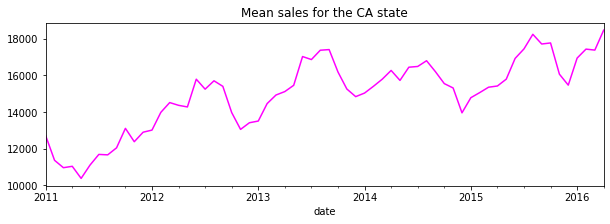

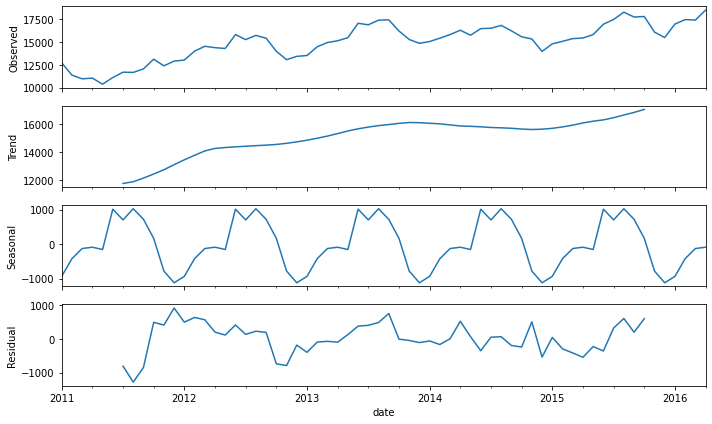

In [39]:
sales("state_id","CA", 'MS', decomp = True)

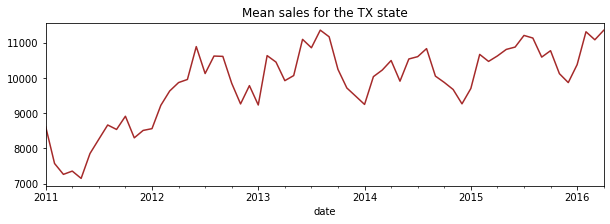

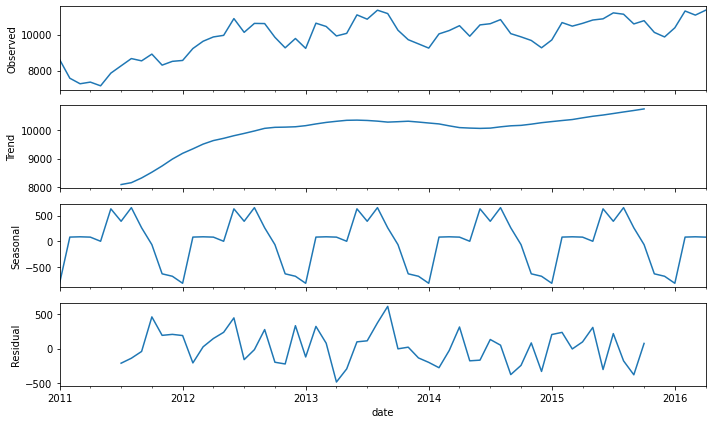

In [40]:
sales("state_id","TX", 'MS', decomp = True)

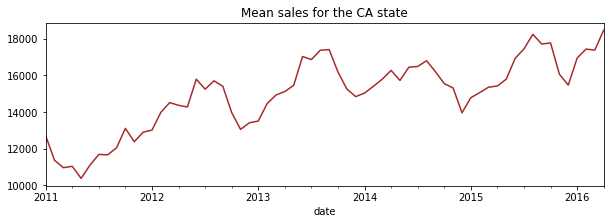

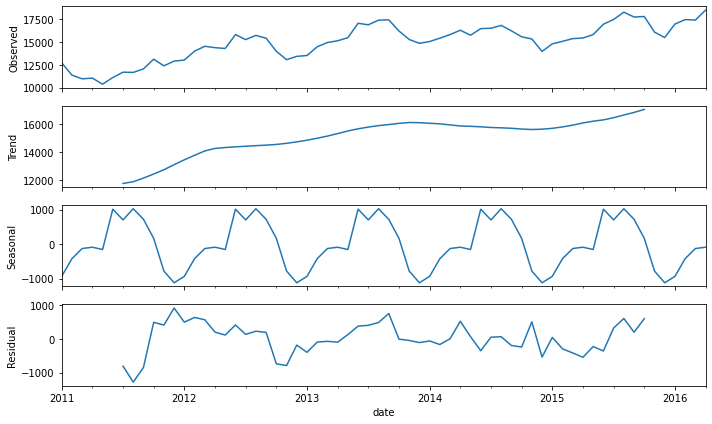

In [41]:
sales("state_id","CA", 'MS', decomp = True)

#### 2.5.2 Stores

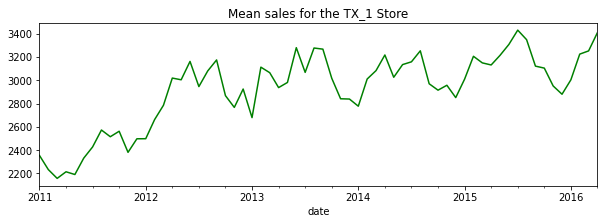

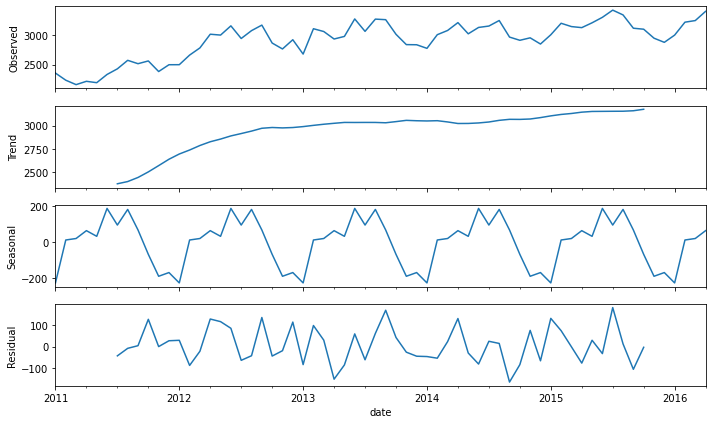

In [42]:
sales("store_id","TX_1", 'MS', decomp = True)

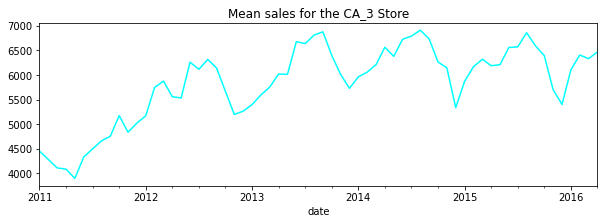

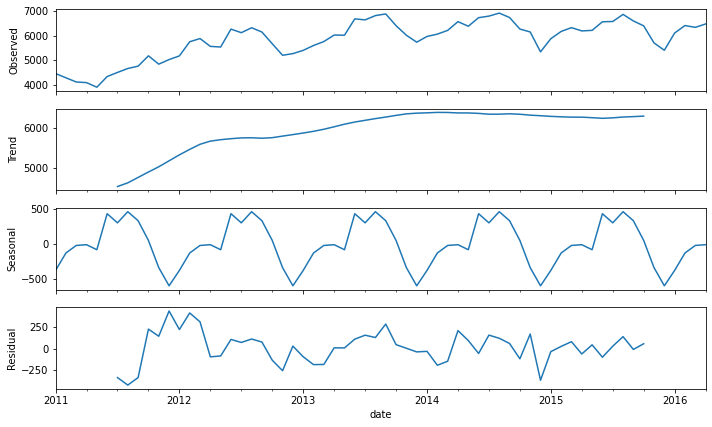

In [43]:
sales("store_id","CA_3", 'MS', decomp = True)

#### 2.5.3 Category

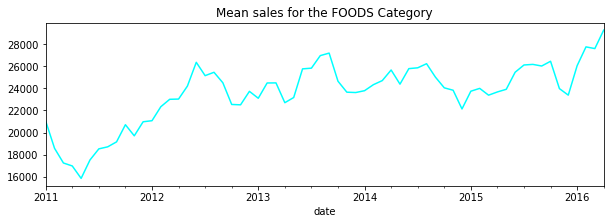

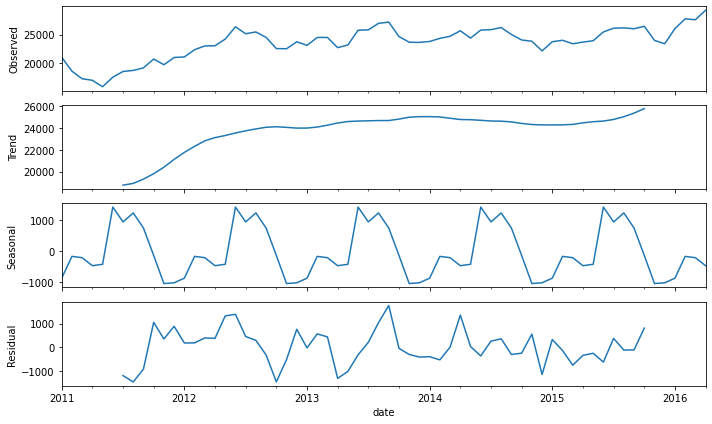

In [44]:
sales("cat_id","FOODS", 'MS', decomp = True)

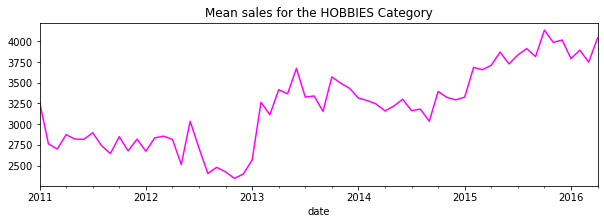

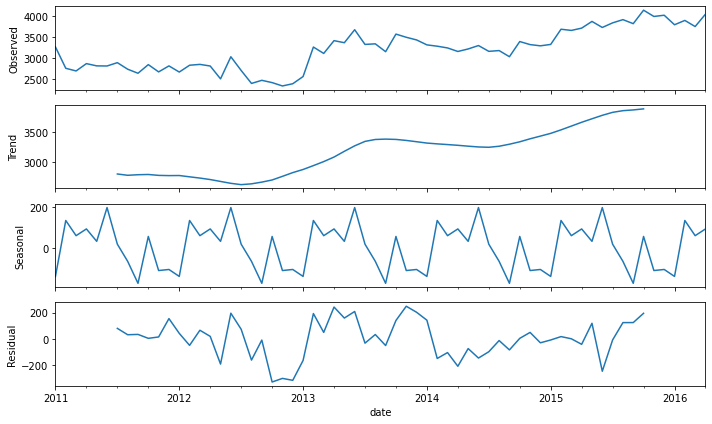

In [45]:
sales("cat_id","HOBBIES", 'MS', decomp = True)

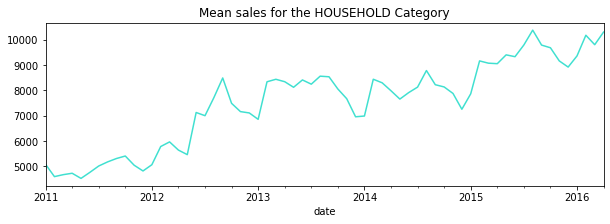

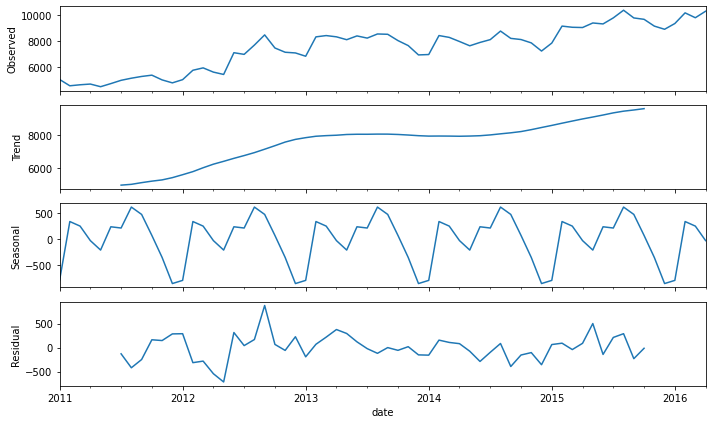

In [46]:
sales("cat_id","HOUSEHOLD", 'MS', decomp = True)

#### 2.5.4 Department

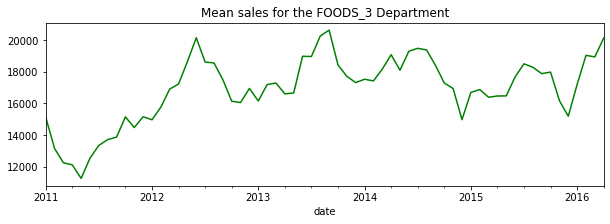

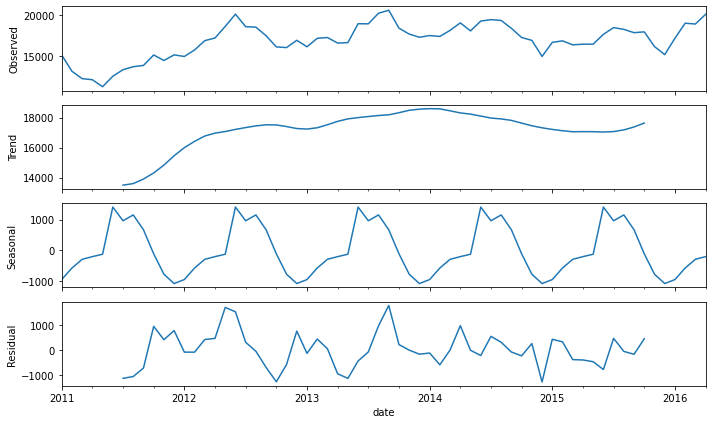

In [47]:
sales("dept_id","FOODS_3", 'MS', decomp = True)

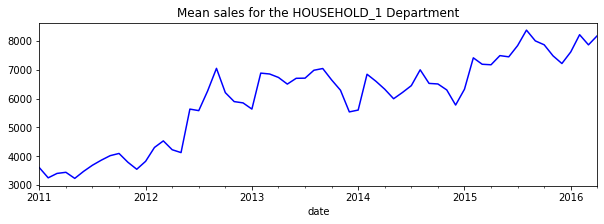

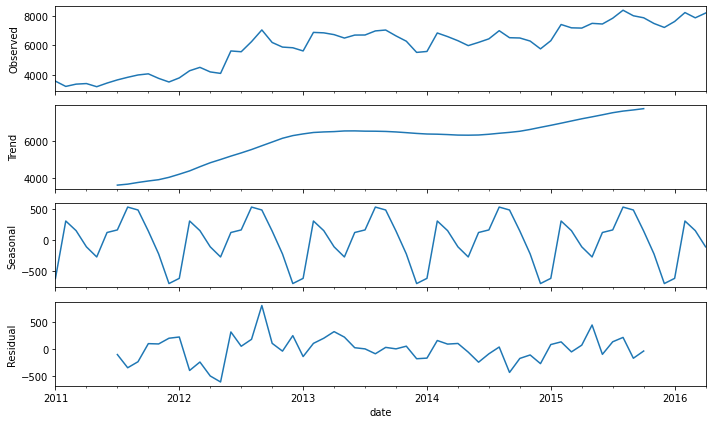

In [48]:
sales("dept_id","HOUSEHOLD_1", 'MS', decomp = True)

In [49]:
plt.style.use('seaborn-bright')

### 2.6 Sales Analysis on state, category and department 

In [50]:
# Plotting Selling Price Distribution across Categories, States and Departments

df = master_df2.groupby(["state_id","cat_id","dept_id"])["sell_price"].agg(["mean","sum"])
df.reset_index(inplace=True)
# plots with plotly

fig1 = px.treemap(df, path=[ 'state_id', 'cat_id',"dept_id"], values='sum',
                  color='sum',hover_data=['sum'])

fig1.show()

In [51]:
### Sales Distribution across Category and Departments

sales_agg_cat = train_val_df.groupby(["state_id","cat_id","dept_id"])[category.columns].sum()
sales_agg_cat = pd.DataFrame(sales_agg_cat.sum(axis=1)).reset_index().rename({0:"sales"}, axis=1)

# Subplots and Pie charts with plotly

fig = make_subplots(rows=1, cols=3,specs=[[{'type':'domain'},{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(values=sales_agg_cat['sales'], labels=sales_agg_cat['state_id']), 1,1)
fig.add_trace(go.Pie(values=sales_agg_cat['sales'], labels=sales_agg_cat['cat_id']), 1,2)
fig.add_trace(go.Pie(values=sales_agg_cat['sales'], labels=sales_agg_cat['dept_id']), 1,3)

# updating traces and layout

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Percentage Sales Distribution across Category and Departments",
    annotations=[dict(text='State', x=0.12, y=0.5, font_size=12, showarrow=False),
        dict(text='Category', x=0.5, y=0.5, font_size=12, showarrow=False),
                 dict(text='Department', x=0.91, y=0.5, font_size=12, showarrow=False)])

fig.show()

### 2.7 Sales Analysis by time (year, months , weeks)

In [52]:
sales_train1 = pd.DataFrame(train_val_df[category.columns].T.sum(axis=1)).rename({0:"sales"}, axis=1).merge(calendar.set_index("d"),how="left", left_index=True,
                                         right_index=True, validate="1:1")

sales_train_year = sales_train1.groupby(["year"])["sales"].sum()
sales_train_year = pd.DataFrame(sales_train_year)

fig = px.bar(sales_train_year.reset_index(), x="year", y="sales", color="year", text="sales", title="Year-wise walmart sales Contribution")
fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [53]:
sales_train_month = sales_train1.groupby(["month"])["sales"].sum()
sales_train_month = pd.DataFrame(sales_train_month)

fig = px.bar(sales_train_month.reset_index(), x="month", y="sales", color="month", text="sales", title="Month-wise Waalmart sales contribution")
fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [54]:
sales_train_weekday= sales_train1.groupby(["month", "weekday"])["sales"].sum()
sales_train_weekday = pd.DataFrame(sales_train_weekday)

fig = px.bar(sales_train_weekday.reset_index(), x="month", y="sales", color="weekday", text="sales", title="Monthly Sales bifurcated by weekdays")
fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [55]:
sales_train_weekday= sales_train1.groupby(["year", "month","weekday"])["sales"].sum()
sales_train_weekday = pd.DataFrame(sales_train_weekday)
sales_train_weekday.reset_index()

stw = sales_train_weekday.reset_index()
colors = ['mediumturquoise', 'lightgreen','darkorange', "red", "cyan", "blue", 'gold']

fig = go.Figure(data=[go.Pie(labels=stw["weekday"],
                             values=stw["sales"], pull=[0, 0.3,0.2 ,0.1 ,0 , 0, 0])])

fig.update_traces(hoverinfo='label+percent+name', textinfo='value', textfont_size=15,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Weekdays sales contribution",
    annotations=[dict(text='Weekdays', x=0.5, y=0.5, font_size=15, showarrow=False)])

fig.show()

In [56]:
master_df2
master_df2['date']= pd.to_datetime(master_df2['date'])
master_df2['year'] = master_df2['date'].dt.year
master_df2['month'] = master_df2['date'].dt.month

In [57]:
event = master_df2.groupby(['event_name_1', 'event_type_1'])['sales'].sum()
event = pd.DataFrame(event)
event = event.drop(['None'], axis=0)
fig = px.bar(event.reset_index(), x="event_name_1", y="sales", color="event_type_1", text="sales", title="Event names 1 and Event type 1 sales wise contribution")
fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [58]:
event = master_df2.groupby(['event_name_2', 'event_type_2'])['sales'].sum()
event = pd.DataFrame(event)
event = event.drop(['None'], axis=0)
fig = px.bar(event.reset_index(), x="event_name_2", y="sales", color="event_type_2", text="sales", title="Event names 2 and Event type 2 sales wise contribution")
fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [59]:
del master_df1, grid_df,train_sales, event, sales_train_weekday, sales_train_month, sales_train1, calender_new, df

# 3. Feature engineering

## 3.1 Lag Introduction

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

Introduces lags to the the target variable sales.

In [60]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    master_df2['sales_lag_'+str(lag)] = master_df2.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sales'].shift(lag).astype(np.float16)

In [61]:
master_df2.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales       date  wm_yr_wk  ...  sell_price  year  month  \
0       CA  d_1     12 2011-01-29     11101  ...        0.46  2011      1   
1       CA  d_2     15 2011-01-30     11101  ...        0.46  2011      1   
2       CA  d_3      0 2011-01-31     11101  ...        0.46  2011      1   
3       CA  d_4      0 2011-02-01     11101  ...        0.46  2011      2   
4       CA  d_5      0 2011-02-02     11101  ...        0.46  2011      2   

  sales_lag_1 sales_lag_2 sales_lag_3 sales_lag_6  sales_lag_12  sales_lag_24  \
0         NaN         NaN         NaN         NaN           NaN           NaN   
1        12.0         NaN         NaN         NaN           NaN           NaN   
2        15.0        12.0         NaN         NaN           NaN           NaN   
3         0.0        15.0        12.0         NaN           NaN           NaN   
4         0.0         0.0        15.0         NaN           NaN           NaN   

   sales_lag_36  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

[5 rows x 27 columns]

## 3.2 Mean Encoding

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value.

In [62]:
master_df2['iteam_sold_avg'] = master_df2.groupby('item_id')['sales'].transform('mean').astype(np.float16)
master_df2['state_sold_avg'] = master_df2.groupby('state_id')['sales'].transform('mean').astype(np.float16)
master_df2['store_sold_avg'] = master_df2.groupby('store_id')['sales'].transform('mean').astype(np.float16)
master_df2['cat_sold_avg'] = master_df2.groupby('cat_id')['sales'].transform('mean').astype(np.float16)
master_df2['dept_sold_avg'] = master_df2.groupby('dept_id')['sales'].transform('mean').astype(np.float16)

In [63]:
master_df2['cat_dept_sold_avg'] = master_df2.groupby(['cat_id','dept_id'])['sales'].transform('mean').astype(np.float16)
master_df2['store_item_sold_avg'] = master_df2.groupby(['store_id','item_id'])['sales'].transform('mean').astype(np.float16)
master_df2['cat_item_sold_avg'] = master_df2.groupby(['cat_id','item_id'])['sales'].transform('mean').astype(np.float16)
master_df2['dept_item_sold_avg'] = master_df2.groupby(['dept_id','item_id'])['sales'].transform('mean').astype(np.float16)
master_df2['state_store_sold_avg'] = master_df2.groupby(['state_id','store_id'])['sales'].transform('mean').astype(np.float16)
master_df2['state_store_cat_sold_avg'] = master_df2.groupby(['state_id','store_id','cat_id'])['sales'].transform('mean').astype(np.float16)
master_df2['store_cat_dept_sold_avg'] = master_df2.groupby(['store_id','cat_id','dept_id'])['sales'].transform('mean').astype(np.float16)

## 3.3 Rolling mean 

I am calculating the weekly rolling avearge of the sales

In [64]:
master_df2['rolling_sales_mean'] = master_df2.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

## 3.4 Expanding mean

In [65]:
master_df2['expanding_sold_mean'] = master_df2.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [66]:
master_df2.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales       date  wm_yr_wk  ...  dept_sold_avg  \
0       CA  d_1     12 2011-01-29     11101  ...       0.865234   
1       CA  d_2     15 2011-01-30     11101  ...       0.865234   
2       CA  d_3      0 2011-01-31     11101  ...       0.865234   
3       CA  d_4      0 2011-02-01     11101  ...       0.865234   
4       CA  d_5      0 2011-02-02     11101  ...       0.865234   

   cat_dept_sold_avg  store_item_sold_avg cat_item_sold_avg  \
0                NaN             7.230469               NaN   
1                NaN             7.230469               NaN   
2                NaN             7.230469               NaN   
3                NaN             7.230469               NaN   
4                NaN             7.230469               NaN   

  dept_item_sold_avg state_store_sold_avg state_store_cat_sold_avg  \
0                NaN             1.636719                 1.003906   
1                NaN             1.636719                 1.003906   
2                NaN             1.636719                 1.003906   
3                NaN             1.636719                 1.003906   
4                NaN             1.636719                 1.003906   

   store_cat_dept_sold_avg  rolling_sales_mean  expanding_sold_mean  
0                      NaN                 NaN                  NaN  
1                      NaN                 NaN            13.500000  
2                      NaN                 NaN             9.000000  
3                      NaN                 NaN             6.750000  
4                      NaN                 NaN             5.398438  

[5 rows x 41 columns]

In [67]:
#Saving the Dataframe to start modeling
master_df2.to_pickle("master_df2.pkl")

In [68]:
masterdf = pd.read_pickle("master_df2.pkl")